# Water Potability Prediction

In [1]:
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import re
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


In [113]:
df = pd.read_csv("drinking_water_potability.csv")

In [116]:
df = df.sample(frac=1).reset_index(drop=True).dropna()
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.560392,223.232250,14739.068540,6.731611,372.028909,481.341774,8.900409,62.134281,4.257805,1
2,9.239440,212.569076,14829.624210,7.172920,324.128915,575.421968,16.581120,66.885270,3.471971,1
4,6.321259,207.257710,8532.139517,5.987877,286.489280,491.765313,10.546886,74.502808,4.501457,0
7,4.901907,141.930781,13614.750930,8.306960,368.618688,439.055356,9.921623,82.660165,4.103534,1
9,7.381758,203.460302,1372.091043,11.129154,475.737460,361.342496,16.548438,55.132546,3.338022,1
...,...,...,...,...,...,...,...,...,...,...
3262,5.497580,204.682870,29493.422970,7.604130,323.608786,476.844459,16.672415,83.413838,5.060115,0
3264,5.575921,223.374007,14553.132310,9.689175,234.609808,252.968328,12.249489,59.523003,4.294448,0
3269,6.792407,306.627481,28508.216930,6.811416,293.078305,306.115539,9.006143,60.912034,2.505650,1
3271,5.117914,179.701677,26215.401100,5.502903,303.257592,369.618616,14.761878,82.831554,3.806700,0


### KNN Model

In [4]:
# Step 1:
# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
	distance = 0.0
	# print("\nr1:", row1)
	# print("\nr2:", row2)
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return np.sqrt(distance)

In [5]:
def p_root(value, root):
     
    root_value = 1 / float(root)
    return round (Decimal(value) **
             Decimal(root_value), 3)
 
def minkowski_distance(x, y, p_value):
     
    # pass the p_root function to calculate
    # all the value of vector parallelly
    return (p_root(sum(pow(abs(a-b), p_value)
            for a, b in zip(x, y)), p_value))

In [6]:
# Locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors):
	distances = list()
	for train_row in train:
		# print("TRAIN: ", train_row)
		# print("\n\nTEST: ", test_row)
		dist = euclidean_distance(train_row, test_row)
		distances.append((train_row, dist))
	distances.sort(key=lambda tup: tup[1])
	neighbors = list()
	for i in range(num_neighbors):
		neighbors.append(distances[i][0])
	return neighbors

In [7]:
# Make a classification prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
	neighbors = get_neighbors(train, test_row, num_neighbors)
	output_values = [row[-1] for row in neighbors]
	#print(output_values)
	prediction = max(set(output_values), key=output_values.count)
	return prediction

### Logestic Regression Model 

In [48]:
# Standardizing the data
"""We Standardize the date around its mean with a unit standard deviation.
We do this so that the data with a higher range do not dominate the outcome. 
We do it for this model because the features are on diffrent scales."""

def standardize(X):
    for col in X.columns:
        X[col] = (X[col] - X[col].mean()) / X[col].std()


# Sigmoid function
"""In Logistic Regression the final outcome is a class such as "yes" or "no".
Whereas in Linear regression the final outcome is determined by an equation that can output a contineous value.
Since we need our final value to be a binomial value (in this case 0 or 1) we would use a sigmoid function that limit our output between 0 and 1.
"""
def sigmoid(x):
        sig = 1/(1 + np.exp(-x))
        return sig


"""We also need a cost/loss function that calculates how far we are from our goal.
Linear refression utilizes least squared error which is a non-convex function. 
Since we are going to rely on gradient decent to optemize our predictions 
we will be using log loss function that is a convex function so that during our decent
we get stuck in a local minimum.
"""

def fit_logestic(X, y, learning_Rate = 0.0001, n_iterations = 100):
        w = np.zeros(X.shape[1])
        b = 0

        for i in range(n_iterations):
                w, b = update_weights(X, y, w, b, learning_Rate)
        return w, b
                


def update_weights(X, y, w, b, learning_rate):
    A = sigmoid(X.dot(w) + b)
    # calculating the gradient decent
    temp = np.reshape(A - y.T, X.shape[0])
    dw = np.dot(X.T, temp)
    db = np.sum(temp) / X.shape[0]
    w = w - learning_rate * dw
    b = b - learning_rate * db
    return w, b


def precict_logestic(X, w, b):
    Z = sigmoid(X.dot( w ) + b)
    Y = np.where( Z > 0.5, 1, 0 )        
    return Y

### Gaussian NB Classifier

In [9]:
def gaussian_class_conditional(X,y):
    probs = {}
    for cols in X.columns:
        new_df = pd.concat([X[cols], y], axis=1)
        new_df = new_df.groupby(y.name)
        mean, var = new_df[cols].mean(), new_df[cols].var()
        probs[cols] = (mean, var)
    return probs

In [10]:
def gaussian_posteriors(probs,priors,x):
    post_probs = {}
    mult_stuff = {}
    keys = []
    idx = x.index
    denominator_sum = 0
    
    for i in priors.keys():
        mult = priors[i]
        key = i + '|'
        param = []
        for col, val in zip(idx, x):
            post_key = f"{col}"
            mean, var = probs[post_key]

            u = i[i.index('=') + 1:]
            index = int(u) if str.isdigit(u) else u
            part1 = 1 / np.sqrt(2 * np.pi * var[index])
            part2 = (val - mean[index]) ** 2
            part3 = 2 * var[index]
            mult *= part1 * np.exp(-1 * (part2 / part3)) 
            param.append(f"{col}={val}")
        key = key + ','.join(param)
        mult_stuff[key] = mult
        keys.append(key)
        denominator_sum += mult
    
    for i in range(len(mult_stuff)):
        post_probs[keys[i]] = (mult_stuff[keys[i]] / denominator_sum) if denominator_sum !=0 else 0
    return post_probs

In [11]:
def compute_priors(y):
    priors = {}
    probs = dict(y.value_counts() / len(y))
    name = y.name + '='
    priors = {name+str(key) : value for (key, value) in probs.items()}
    return dict(collections.OrderedDict(sorted(priors.items())))

In [12]:
def my_func(a, b, c, col_type):
    probs = gaussian_posteriors(b, c, a)
    u = max(probs, key = probs.get)
    return col_type(re.search('[=](.*)[\|]', u).group(1))

def predict_gaussian(Xtrain, ytrain, Xtest):
    probs = gaussian_class_conditional(Xtrain, ytrain)
    priors = compute_priors(ytrain)
    return Xtest.apply(my_func, axis = 1, args = (probs,priors, type(ytrain.iloc[0])))

In [13]:
X, y = df[df.columns[:-1]], df[df.columns[-1]]

In [14]:
''' train test split '''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
''' standard scaler '''
sc = StandardScaler()
sc.fit(X_train)
standardize(X_train)
X_test = sc.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X_train.columns)

### Testing models made by us

In [153]:
results_acc = []
result_name = []

#### Logestic Regression

In [154]:
W, b = fit_logestic(X_train, y_train)
y_pred = precict_logestic(X_test, W, b)
results_acc.append(accuracy_score(y_test, y_pred))
result_name.append('LogisticRegression')

#### KNN classifier

In [155]:
data = X_train.copy()
data[y_train.name] = y_train
data = data.to_numpy()
max_acc = -np.inf
test = X_test.to_numpy()
best_c = 0
acc = []
neigh = []
for c in range(1, 20):
    pred = []
    for i in test:
        prediction = predict_classification(data, i, c)
        pred.append(prediction)
    
    a = accuracy_score(y_test, pred)
    acc.append(a)
    neigh.append(c)
    if a > max_acc:
        max_acc = a
        best_c = c

results_acc.append(max_acc)
result_name.append("KNeighborsClassifier")

#### Gaussian NB

In [156]:
y_pred = predict_gaussian(X_train, y_train, X_test)
results_acc.append(accuracy_score(y_test, y_pred))
result_name.append('GaussianNB')

### Plotting our results

Text(0, 0.5, 'Model Name')

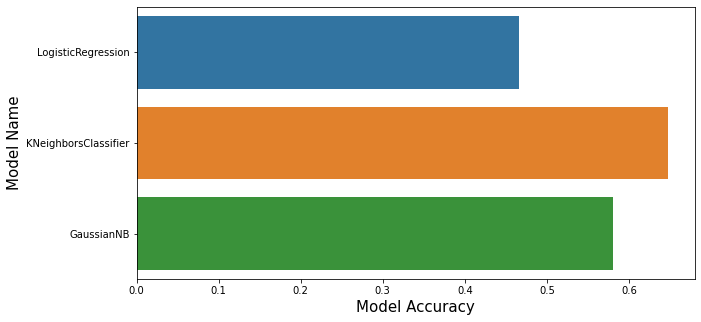

In [157]:
''' barplot plot models accuracy '''
plt.figure(figsize=(10, 5))
sns.barplot(results_acc, result_name,)
plt.xlabel('Model Accuracy', fontsize=15)
plt.ylabel('Model Name', fontsize=15)

### Testing the inbuilt models

In [158]:
models_acc = []

models = [LogisticRegression(penalty='none'), KNeighborsClassifier(metric='euclidean', n_neighbors=best_c), GaussianNB()]

for model in models:
    ''' fit on data '''
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    
    ''' appending result to model_acc'''
    models_acc.append(accuracy_score(y_test, pred))

In [159]:
''' creating dataframe '''
res = pd.DataFrame({
    'Model Accuracy': models_acc, 
    "Model Name": ['LogisticRegression', 'KNeighborsClassifier', 'GaussianNB']
})

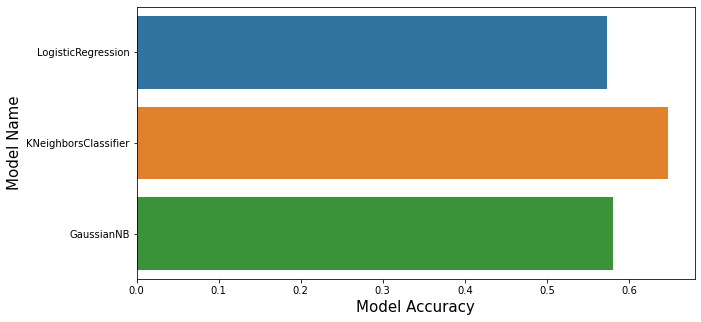

In [160]:
''' barplot plot models accuracy '''
plt.figure(figsize=(10, 5))
sns.barplot(res['Model Accuracy'], res['Model Name'])
plt.xlabel('Model Accuracy', fontsize=15)
plt.ylabel('Model Name', fontsize=15);

In [161]:
model_results = []
for i in range(3):
    model_results.append([results_acc[i], result_name[i], "Self Implemented"])

In [162]:
res["Type"] = "Scikit-learn"
for i in model_results:
    res.loc[len(res) + 1] = i

res

,Model Accuracy,Model Name,Type
0,0.573201,LogisticRegression,Scikit-learn
1,0.647643,KNeighborsClassifier,Scikit-learn
2,0.580645,GaussianNB,Scikit-learn
4,0.466501,LogisticRegression,Self Implemented
5,0.647643,KNeighborsClassifier,Self Implemented
6,0.580645,GaussianNB,Self Implemented


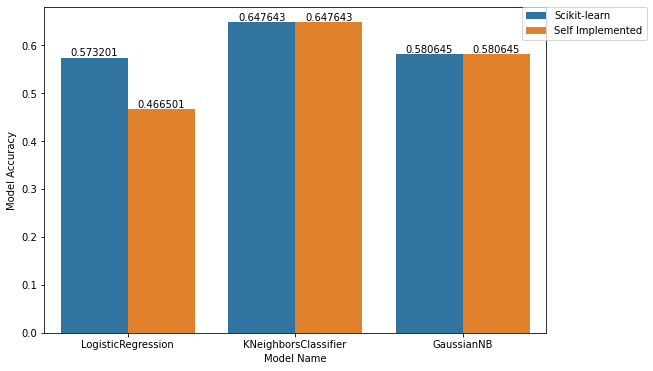

In [163]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 9, 6

ax = sns.barplot(x="Model Name", y="Model Accuracy", hue="Type", data=res, ci="sd", errwidth=0)
for i in ax.containers:
    ax.bar_label(i,)
plt.legend( bbox_to_anchor=(1.2, 1), borderaxespad=0)

In [164]:
# import dataframe_image as dfi
# data = X_train.copy()
# data[y_train.name] = y_train
# data = data.reset_index(drop=True)
# dfi.export(data.head(10), 'dataframe.png')

[0311/172554.766758:INFO:headless_shell.cc(659)] Written to file /var/folders/_y/djxc8y154lqd3g7r7v5z_c8w0000gn/T/tmpyvf5kwgz/temp.png.


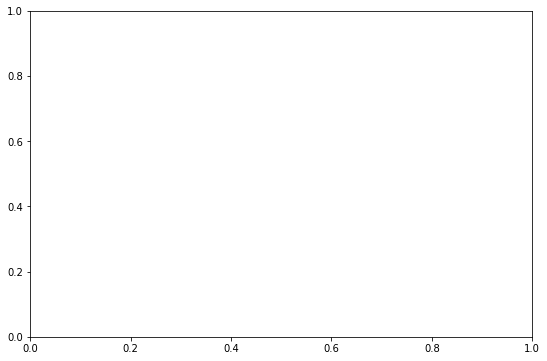

In [165]:
# for i in ['LogisticRegression', 'KNeighborsClassifier', 'GaussianNB']:
#     lr = res[res['Model Name'] == i]
#     lr['Model Accuracy'] *= 100
#     ax = None
#     ax = sns.barplot(x="Type", y="Model Accuracy", data=lr)
#     for j in ax.containers:
#         ax.bar_label(j,)
#     ax.set(title = i)
#     ax.figure.savefig(i + '.png')
#     ax.clear()

In [182]:
# import altair as alt
# source = pd.DataFrame({
#   'neighbors': neigh,
#   'accuracy': acc
# })
# scale=alt.Scale(zero=False)
# u = alt.Chart(source).mark_line().encode(
#     x='neighbors',
#     y=alt.Y('accuracy', scale=alt.Scale(zero=False)), 

# )
# u

alt.Chart(...)